In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# Data preview / Cleaning

In [8]:
df = pd.read_csv('../dataset_mood_smartphone.csv')
df = df.drop('Unnamed: 0', axis = 1)
df[['day', 'time']] = df['time'].str.split(' ', expand=True)
variables = df['variable'].unique()
ids = df['id'].unique()
days = df['day'].unique()
times = df['time'].unique()

## Tables creation

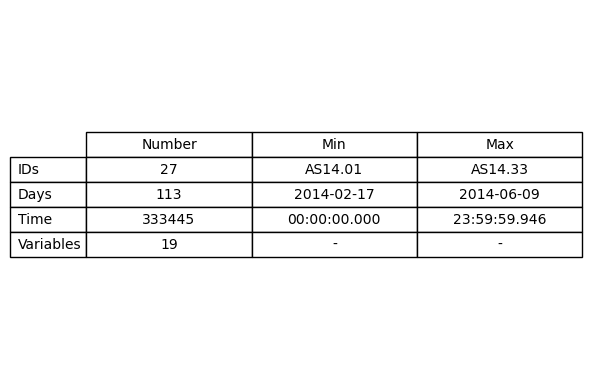

In [39]:
columns = ['Number', 'Min', 'Max']
rows = ['IDs','Days','Time', 'Variables']
table = pd.DataFrame(index = rows,columns= columns)
low_range = df.min()
up_range = df.max()
table.loc['IDs'] = [ids.shape[0],low_range['id'], up_range['id']]
table.loc['Days'] = [days.shape[0],low_range['day'], up_range['day']]
table.loc['Time'] = [times.shape[0],low_range['time'], up_range['time']]
table.loc['Variables'] = [variables.shape[0],'-' , '-']

fig, ax = plt.subplots()
ax.axis('off')
table_ax = plt.table(cellText=table.values, colLabels=table.columns, rowLabels=table.index, cellLoc = 'center', loc='center')

table_ax.auto_set_font_size(False)
table_ax.set_fontsize(10)
table_ax.scale(1, 1.5)

plt.savefig('table.png')

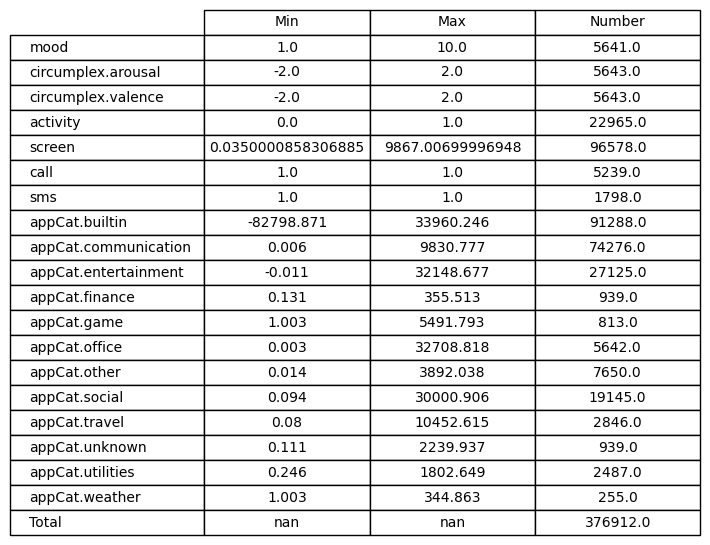

In [40]:
table_var = pd.DataFrame(index = variables, columns= [ 'Min', 'Max', 'Number'])

var_range = []
for i,var in enumerate(variables):
    data = df[df['variable'] == var]['value']
    var_range += [np.array([np.min(data), np.max(data), data.shape[0]])]
for i,var in enumerate(variables):
    table_var.iloc[i] = var_range[i]
    
# Calculate the sum of the 'Number' column
total_number = table_var['Number'].sum()

# Add a row with the sum of the 'Number' column
table_var.loc['Total', 'Number'] = total_number

table_var.rename_axis('Variables', axis='index', inplace=True)

fig, ax = plt.subplots()
ax.axis('off')
table_ax = plt.table(cellText=table_var.values, colLabels=table_var.columns, rowLabels=table_var.index, cellLoc = 'center', loc='center')

table_ax.auto_set_font_size(False)
table_ax.set_fontsize(10)
table_ax.scale(1, 1.5)
table_var.to_excel("output.xlsx")
plt.savefig('table_var.png')

In [47]:
#Table of time and date ranger per id as well as the average hour of the day that each ID records stuff 

days_per_id = df.groupby('id')['day'].nunique().reset_index()
days_per_id.columns = ['id', 'Number of Days']
day_range = df.groupby('id')['day'].agg(['min', 'max']).reset_index()
day_range.columns = ['id', 'Earliest Day', 'Latest Day']
days_per_id = days_per_id.merge(day_range, on='id')
days_per_id.to_excel("info_id.xlsx")

## Plots

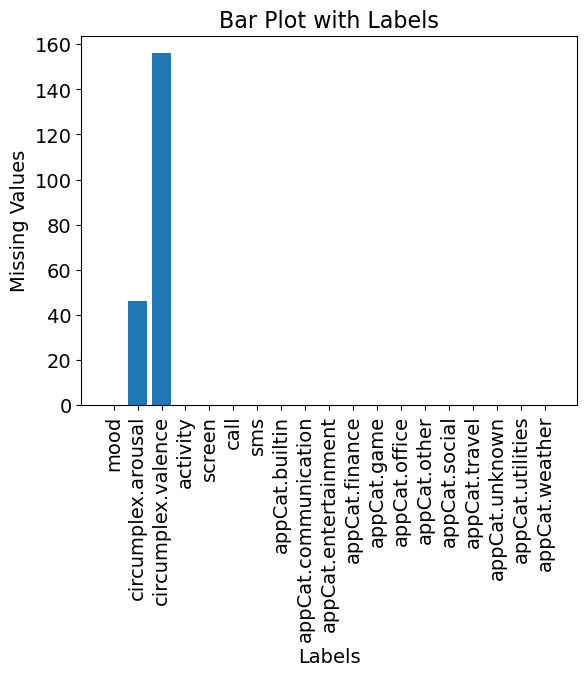

In [6]:
zeros_var = np.zeros(variables.shape[0])

for i,var in enumerate(variables):
    df_min = df[df['variable'] == var]
    zeros_var[i] = df_min.isna().sum().sum()

fig, ax = plt.subplots()


ax.bar(variables, zeros_var)

ax.set_xlabel('Labels')
ax.set_ylabel('Missing Values')
ax.set_title('Bar Plot with Labels')
plt.xticks(rotation='vertical')

plt.show()

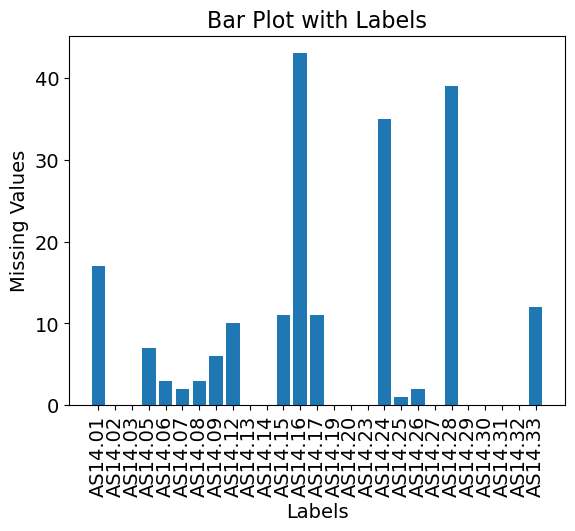

In [7]:
zeros_ids = np.zeros(ids.shape[0])

for i,var in enumerate(ids):
    df_min = df[df['id'] == var]
    zeros_ids[i] = df_min.isna().sum().sum()

fig, ax = plt.subplots()


ax.bar(ids, zeros_ids)

ax.set_xlabel('Labels')
ax.set_ylabel('Missing Values')
ax.set_title('Bar Plot with Labels')
plt.xticks(rotation='vertical')

plt.show()

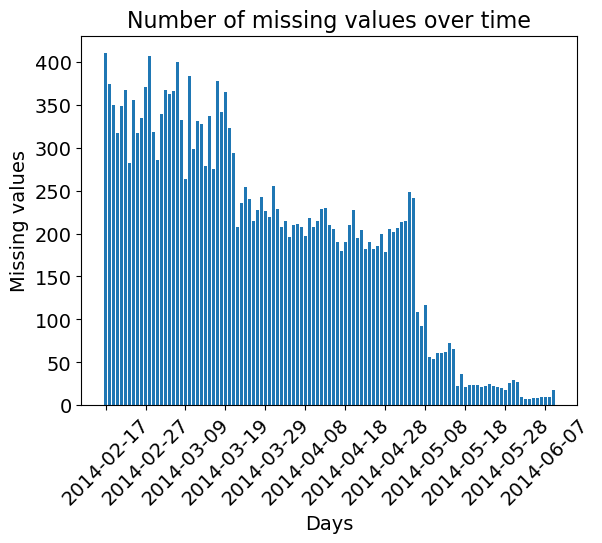

In [51]:
'''function that plots over time the missing values for all the variables'''

missing_values = np.zeros(days.shape[0])
empty_values = np.zeros(days.shape[0])
df1 = pd.read_csv('..//daily_aggregate.csv')


for i,var in enumerate(days):
    df1_min = df1[df1['date'] == var]
    missing_values[i] = df1_min.isna().sum().sum()

 
fig, ax = plt.subplots()
ax.bar(days, missing_values, label='NaN values')

ax.set_xlabel('Days')
ax.set_ylabel('Missing values')
ax.set_title('Number of missing values over time')


ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.xticks(rotation=45)
plt.savefig('missing_values.png')
plt.show()

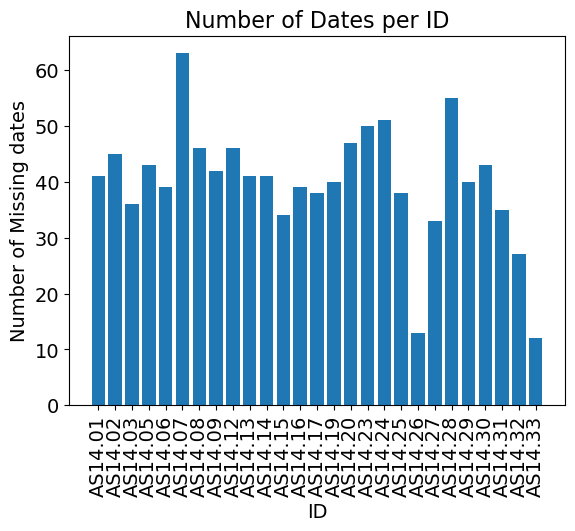

In [71]:
missing_dates = []

for id in ids:
    df_id = df[df['id'] == id]
    unique_dates_for_id = df_id['day'].unique()
    num_missing_dates = len(set(days) - set(unique_dates_for_id))
    
    missing_dates.append(num_missing_dates)

    
fig, ax = plt.subplots()
ax.bar(ids , missing_dates)

ax.set_xlabel('ID')
ax.set_ylabel('Number of Missing dates')
ax.set_title('Number of Dates per ID')
plt.xticks(rotation='vertical')

plt.show()

/var/folders/tw/4rsv6x912cjcqzlsdtp5_vjr0000gn/T/ipykernel_2368/1756248903.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mood['time'] = pd.to_datetime(df_mood['time'])
/var/folders/tw/4rsv6x912cjcqzlsdtp5_vjr0000gn/T/ipykernel_2368/1756248903.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mood['date'] = df_mood['time'].dt.date


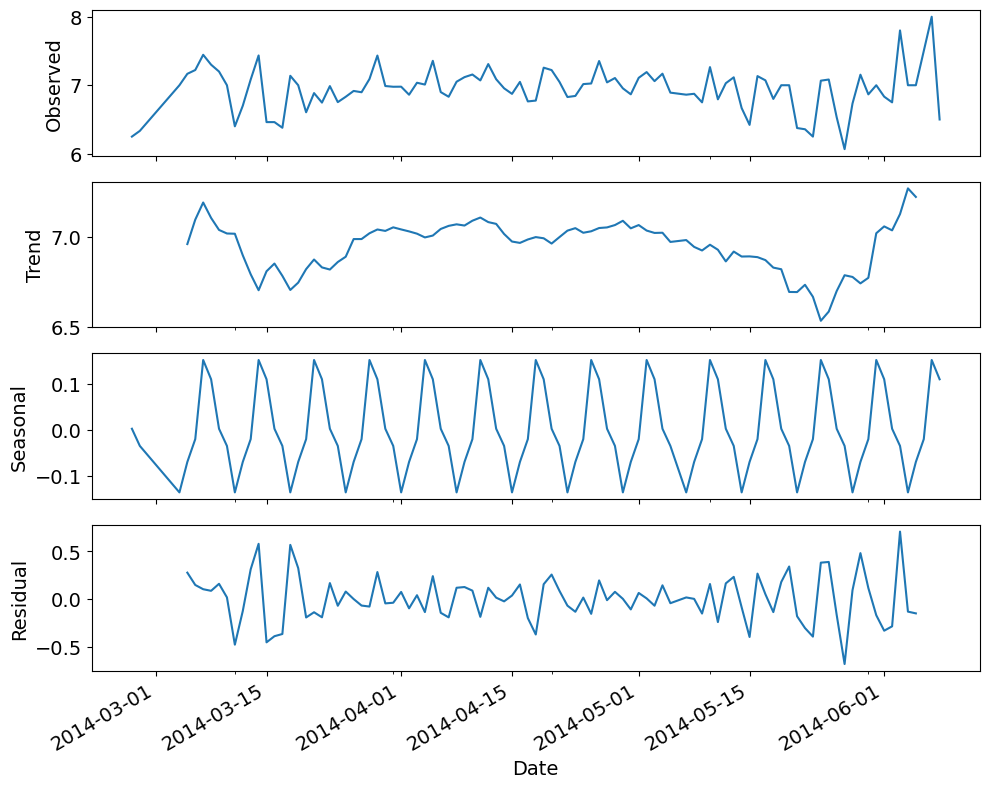

In [74]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

file_path = "dataset_mood_smartphone.csv"
df = pd.read_csv(file_path)
df_mood = df[df['variable'] == 'mood']
df_mood['time'] = pd.to_datetime(df_mood['time'])

df_minute_avg = df_mood.groupby(['time']).agg({'value': 'mean'}).reset_index()
df_mood['date'] = df_mood['time'].dt.date
df_daily_avg = df_mood.groupby(['date']).agg({'value': 'mean'}).reset_index()
df_daily_avg['date'] = pd.to_datetime(df_daily_avg['date'])

# Set 'date' as index
df_daily_avg.set_index('date', inplace=True)

# Perform seasonal decomposition on df_daily_avg
results = seasonal_decompose(df_daily_avg['value'], model='additive', period=7)

# Plot the results
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
results.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
results.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
results.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
results.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
plt.tight_layout()
plt.savefig('seasonal_decomposition.png')
plt.show()





# Task: 1,B

## Moving average